In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
daily_PM10 = pd.read_csv("./daily_all_03_19_Maj.csv", sep=";")   

In [3]:
daily_PM10.head()   # ok

,Jednostka,ug/m3
0,1.05.2003,40.5
1,2.05.2003,43.9
2,3.05.2003,39.5
3,4.05.2003,34.2
4,5.05.2003,55.8


In [4]:
daily_PM10.tail()   # ok

,Jednostka,ug/m3
5840,27.04.2019,39.8
5841,28.04.2019,34.1
5842,29.04.2019,25.0
5843,30.04.2019,29.4
5844,1.05.2019,36.9


In [5]:
daily_PM10.info()   # around 400 null rows...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5845 entries, 0 to 5844
Data columns (total 2 columns):
Jednostka    5845 non-null object
ug/m3        5489 non-null float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB


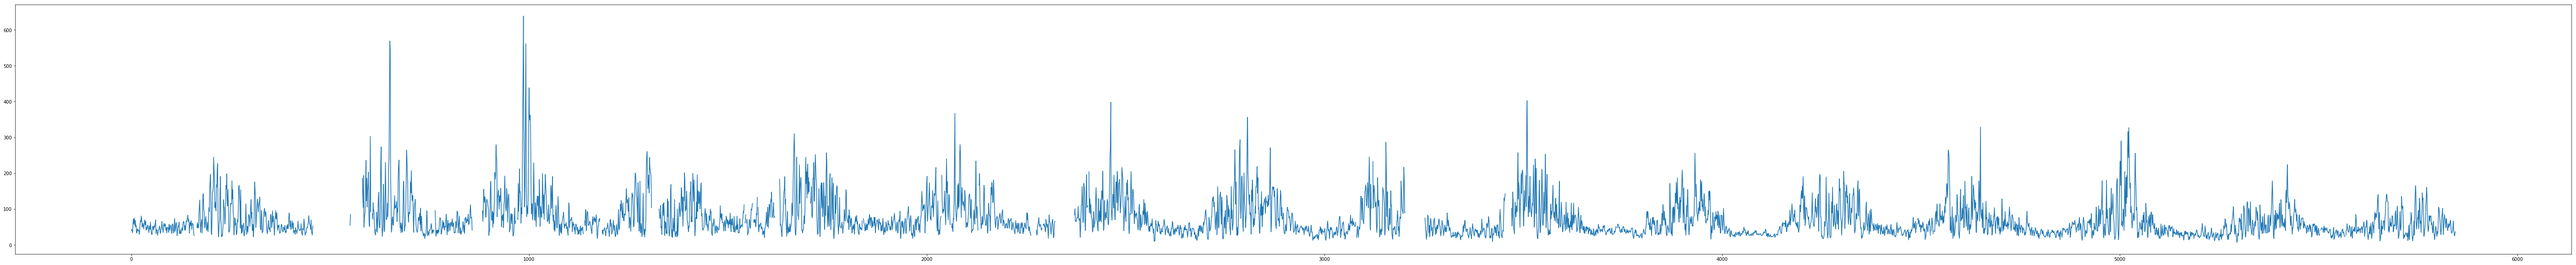

In [6]:
plt.figure(figsize=(100,10))
plt.plot(daily_PM10["ug/m3"])    # already numeric data (Great)
plt.show()

In [7]:
# let's fill the null values

numerical = daily_PM10["ug/m3"]


for i in range(len(numerical)):
    if np.isnan(numerical[i]):      
        numerical[i] = np.mean(numerical[i-5:i+5])


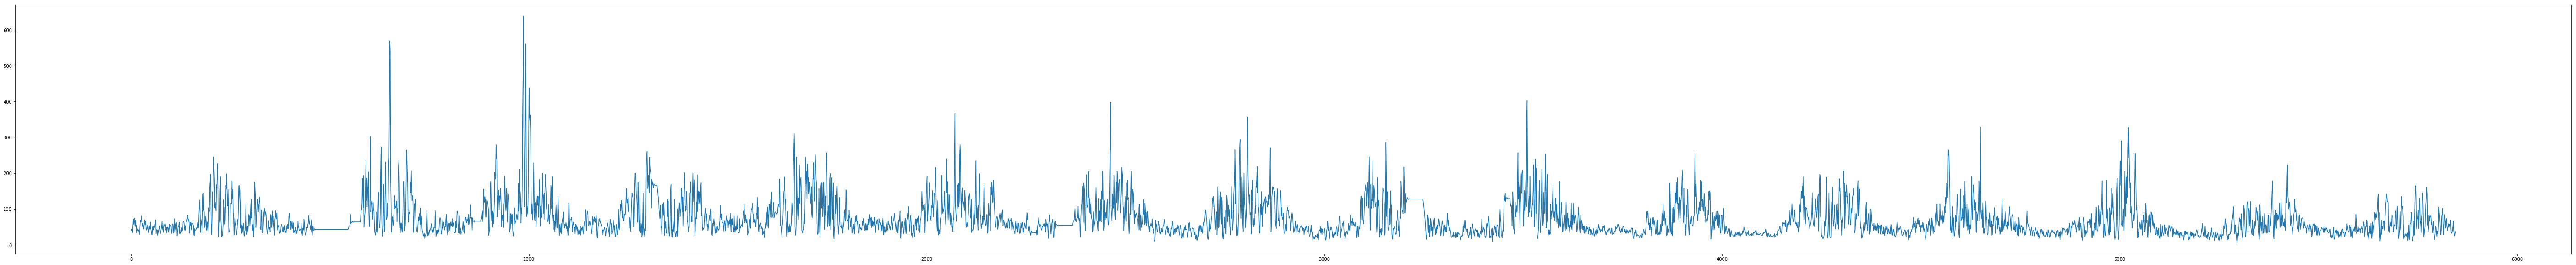

In [8]:
plt.figure(figsize=(100,10))
plt.plot(numerical)    # already numeric data (Great)
plt.show()

In [9]:
frame_size = 400
label_size = 1

numerical = np.array(numerical)

numerical = numerical.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))    
numerical = scaler.fit_transform(numerical)

numerical.shape

(5845, 1)

In [10]:
train_x = []
train_y = []

for x in range(numerical.shape[0]-(frame_size+label_size)):
    train_x.append(numerical[x:(x+frame_size)])
    train_y.append(numerical[(x+frame_size):(x+frame_size+label_size)])

In [13]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [14]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

train_x = train_x.reshape(-1,frame_size,1)
train_y = train_y.reshape(-1,label_size)
test_x = test_x.reshape(-1,frame_size,1)
test_y = test_y.reshape(-1,label_size)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(4899, 400, 1)
(4899, 1)
(545, 400, 1)
(545, 1)


In [15]:
print(np.isnan(train_x).any())
print(np.isnan(train_y).any())
print(np.isnan(test_x).any())
print(np.isnan(test_y).any())

False
False
False
False


In [16]:
model_daily = Sequential()

model_daily.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(train_x.shape[1],1)))
model_daily.add(Dropout(0.15))

model_daily.add(LSTM(40,activation="tanh",return_sequences=False))
model_daily.add(Dropout(0.15))

#model_daily.add(Dense(128,activation="relu", input_shape=(train_x.shape[1],1)))
#model_daily.add(Dropout(0.1))
#model_daily.add(Dense(64,activation="relu"))
#model_daily.add(Dropout(0.1))
#model_daily.add(Dense(32,activation="relu"))
#model_daily.add(Dropout(0.1))
#model_daily.add(Flatten())

#model_daily.add(Dense(16,activation="relu"))
#model_daily.add(Dropout(0.1))
model_daily.add(Dense(1))

In [17]:
model_daily.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400, 40)           6720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_daily.compile(optimizer="adam",loss="mae")

In [19]:
history = model_daily.fit(x=train_x,y=train_y,batch_size=500,epochs=50,validation_data=(test_x,test_y))

Train on 4899 samples, validate on 545 samples
Epoch 1/50
4899/4899 [==============================] - 20s 4ms/step - loss: 0.0634 - val_loss: 0.0549
Epoch 2/50
4899/4899 [==============================] - 15s 3ms/step - loss: 0.0469 - val_loss: 0.0495
Epoch 3/50
4899/4899 [==============================] - 15s 3ms/step - loss: 0.0442 - val_loss: 0.0450
Epoch 4/50
4899/4899 [==============================] - 15s 3ms/step - loss: 0.0415 - val_loss: 0.0439
Epoch 5/50
4899/4899 [==============================] - 16s 3ms/step - loss: 0.0406 - val_loss: 0.0435
Epoch 6/50
4899/4899 [==============================] - 15s 3ms/step - loss: 0.0402 - val_loss: 0.0430
Epoch 7/50
4899/4899 [==============================] - 16s 3ms/step - loss: 0.0402 - val_loss: 0.0429
Epoch 8/50
4899/4899 [==============================] - 18s 4ms/step - loss: 0.0400 - val_loss: 0.0428
Epoch 9/50
4899/4899 [==============================] - 19s 4ms/step - loss: 0.0397 - val_loss: 0.0429
Epoch 10/50
4899/4899 [===

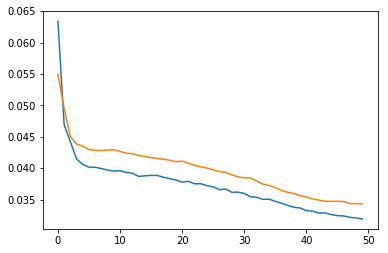

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [21]:
predictions = model_daily.predict(test_x)

In [22]:
predictions[122]

array([0.16180608], dtype=float32)

In [23]:
test_y[122]

array([0.19414557])

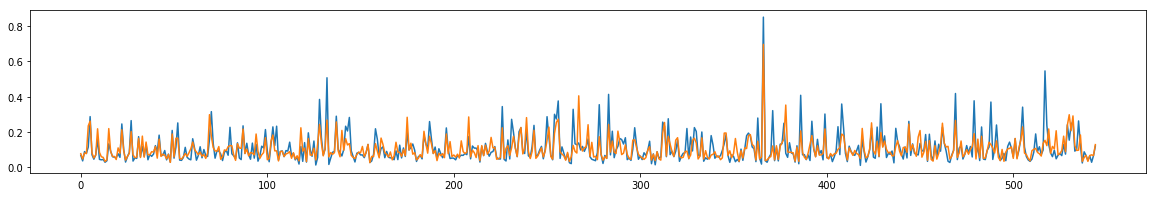

In [24]:
plt.figure(figsize=(20,3))
plt.plot(test_y)
plt.plot(predictions)